In [1]:
from neo4j import GraphDatabase
import pandas as pd
from openai import OpenAI
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import networkx as nx
import mysql.connector
import json
from collections import Counter
import os
from dowhy import CausalModel
import re
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# DB接続処理
# Neo4jに接続
uri = "bolt://localhost:7687"
user = "neo4j"
password = "abcd7890"

# ドライバを作成
driver = GraphDatabase.driver(uri, auth=(user, password))

'tomato','basil','cheese_mozzarella_nonfat','olive_oil'
         aroma_id  food_count  total_ratio
0          bitter           4     1.166366
1           fatty           2     0.569537
2            mild           3     0.334838
3           faint           3     0.329321
4           bread           2     0.277696
5           yeast           2     0.277696
6           baked           2     0.277696
7   slightly_waxy           2     0.238118
8           sweet           1     0.058056
9      sassafrass           1     0.029518
10          green           1     0.029518
11          spice           1     0.029518
12         fennel           1     0.029518
13        alcohol           1     0.029518
14        vanilla           1     0.029518
15       licorice           1     0.029518
16         herbal           1     0.029518
17          minty           1     0.029518
18          anise           1     0.029518
19          lemon           1     0.028538
20       lavender           1     0.02853

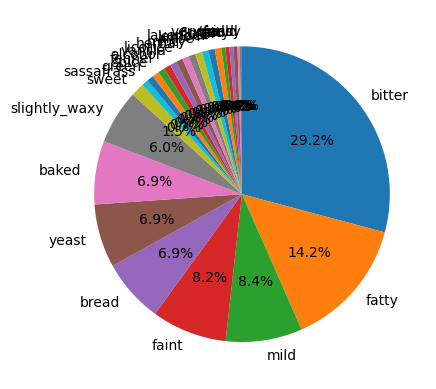

'oyster_raw','kiwi','cucumber'
         aroma_id  food_count  total_ratio
0       very_mild           1     0.499225
1          grassy           1     0.499225
2           fatty           2     0.367313
3           faint           2     0.309084
4          bitter           3     0.266315
5            mild           2     0.185727
6           baked           2     0.160693
7           yeast           1     0.156087
8           bread           1     0.156087
9   slightly_waxy           2     0.111108
10           waxy           2     0.073942
11          fried           1     0.067309
12            fat           1     0.067309
13           lard           1     0.067309
14        coconut           1     0.006634
15          soapy           1     0.006634


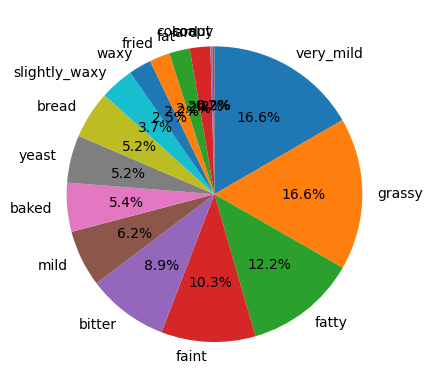

'cabbage'
     aroma_id  food_count  total_ratio
0        mild           1     0.153032
1       baked           1     0.153032
2       bread           1     0.153032
3       yeast           1     0.153032
4      bitter           1     0.132629
5       faint           1     0.085018
6  ammoniacal           1     0.058611
7       fatty           1     0.056679
8   very_mild           1     0.027468
9      grassy           1     0.027468


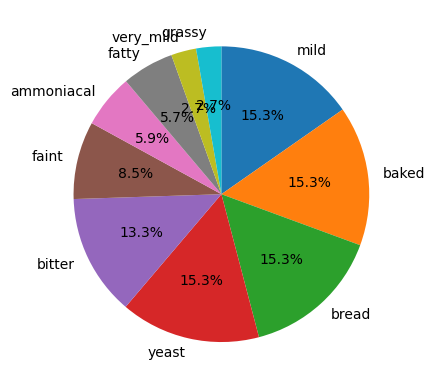

'peach'
   aroma_id  food_count  total_ratio
0     bread           1     0.127851
1     baked           1     0.127851
2     yeast           1     0.127851
3      mild           1     0.127851
4     faint           1     0.115816
5    bitter           1     0.114584
6     fatty           1     0.094106
7     fried           1     0.041022
8       fat           1     0.041022
9      lard           1     0.041022
10     waxy           1     0.041022


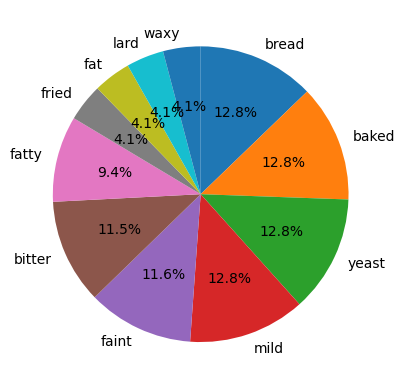

In [3]:
targets=[
    ["tomato", "basil", "mozzarella cheese", "olive oil"],
    ["oyster", "kiwi", "cucumber"],
    ["cabbage"],
    ["peach"]
]

def find_food(tx, search_term):
    find_food_query = """
    CALL db.index.fulltext.queryNodes("food_sub_index_text_search", $search_term)
    YIELD node, score
    ORDER BY score DESC, size(node.name)
    LIMIT 1
    RETURN node.id as node_id, node.name as node_name, score    
    """
    return tx.run(find_food_query, search_term=search_term).data()

def find_aromas(tx, ids):
    find_aromas_query = f"""
    MATCH (f:FoodSubType)-[r:SCENTED]->(a:Aroma)
    WHERE f.id IN [{ids}]
    WITH a.id AS aroma_id, COUNT(f) AS food_count, SUM(r.ratio) AS total_ratio
    RETURN aroma_id, food_count, total_ratio
    ORDER BY total_ratio DESC;
    """
    print(ids)
    return tx.run(find_aromas_query).data()
    
with driver.session() as session:
    for dish in targets:
        node_ids = []
        for target in dish:
            result1 = session.execute_read(find_food, target)  
            for record in result1:
                node_ids.append("'"+ record["node_id"] + "'")
    
        result2 = session.execute_read(find_aromas, ",".join(node_ids))
        pd_result = pd.DataFrame(result2)
        print(pd_result)
        
        plt.pie(
            pd_result['total_ratio'], 
            labels=pd_result['aroma_id'], 
            autopct='%1.1f%%',  # 割合表示
            startangle=90,  # 開始角度を指定
            counterclock=False  # 時計回りに表示
        )
        plt.show()
        plt.close()

## 

## Word2Vec可視化

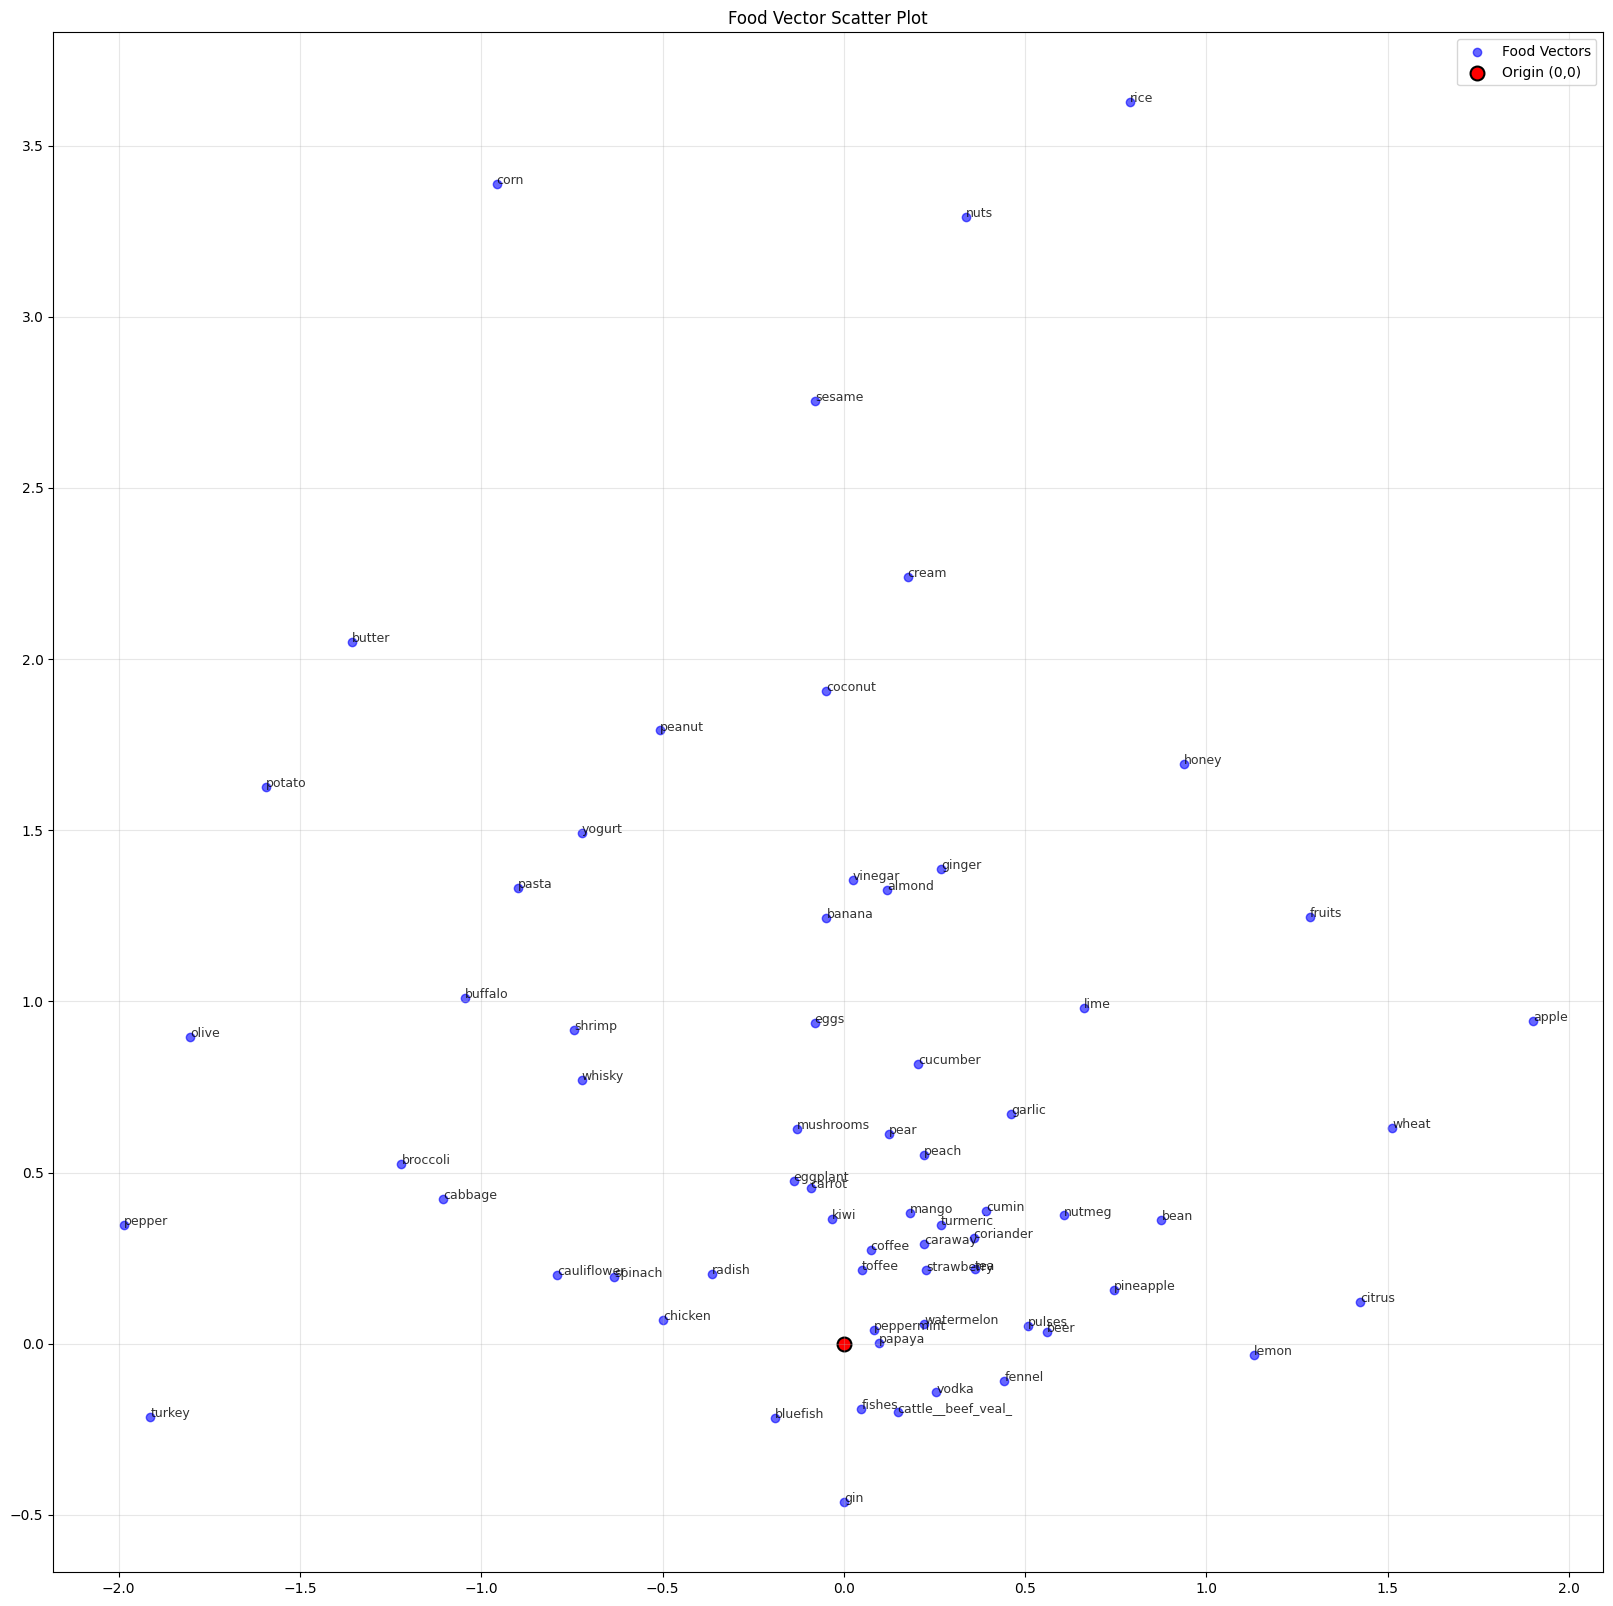

In [4]:
show_items = ['kiwi','garlic','pineapple','peanut','cattle__beef_veal_','chicken','cauliflower','broccoli',
'tea','pepper','papaya','caraway','watermelon','lime','lemon','coffee','coriander','cucumber',
'cumin','turmeric','fennel','strawberry','apple','mango','peppermint','nutmeg','olive','rice',
'almond','peach','pear','radish','sesame','eggplant','potato','spinach','corn','ginger','banana',
'carrot','beer','pasta','bluefish','buffalo','coconut','turkey','shrimp','wheat','eggs','yogurt',
'bean','vodka','whisky','gin','honey','vinegar','toffee','butter','cream','cabbage','mushrooms',
'citrus','fishes','pulses','nuts','fruits']

def find_food(tx):
    # クエリ実行と結果の取得
    return tx.run("MATCH (f:Food) RETURN f").data()

vectors = []
labels = []

with driver.session() as session:
    # クエリ結果をループ処理
    foods = session.execute_read(find_food)
    for i, record in enumerate(foods):
        vec = np.array(record["f"]["word_vector"])
        if record["f"]["id"] in show_items:
            vectors.append(vec)            
            labels.append((vec[:2], record["f"]["id"]))
            
vectors = np.array(vectors)
# 散布図をプロット
plt.figure(figsize=(20, 20))
plt.scatter(vectors[:, 0], vectors[:, 1], alpha=0.6, c="blue", label="Food Vectors")

# ラベルをプロット（10個に1つだけ）
for (x, y), label in labels:
    plt.text(x, y, label, fontsize=9, alpha=0.8)
    
plt.scatter(0, 0, c="red", s=100, label="Origin (0,0)", edgecolors="black", linewidth=1.5)
plt.title("Food Vector Scatter Plot")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### similarityの可視化

In [5]:
def project_similarity_graph(tx):
    tx.run("""
        CALL gds.graph.list() 
        YIELD graphName WITH graphName 
        WHERE graphName = 'kmeansGraph' 
        CALL gds.graph.drop('kmeansGraph') 
        YIELD graphName AS droppedGraph RETURN droppedGraph;
    """)
    tx.run("""
        CALL gds.graph.project(
            'kmeansGraph',
            {
                Food: {
                    properties: ['word_vector', 'flavor_vector']
                }
            },
            {
                CONTAINS: {
                    orientation: 'UNDIRECTED'
                }
            }
        );
     """)
    
def fetch_pagerank_and_edges():
    # Word2Vecのクラスタリングを取得
    word_query = """
        CALL gds.kmeans.stream('kmeansGraph', {
            nodeLabels: ['Food'],
            relationshipTypes: ['CONTAINS'],
            k: 100, // クラスタの数を指定
            maxIterations: 100, // 最大反復回数
            nodeProperty: 'word_vector' // クラスタリングに使用するプロパティ
        })
        YIELD nodeId, communityId, distanceFromCentroid, silhouette
        WITH gds.util.asNode(nodeId) AS node, communityId, distanceFromCentroid, silhouette
        RETURN node.id as id, node.name AS name, communityId, distanceFromCentroid, silhouette
        ORDER BY communityId, distanceFromCentroid;
    """
    
    # Flavorのクラスタリングを取得
    flavor_query = """
        CALL gds.kmeans.stream('kmeansGraph', {
            nodeLabels: ['Food'],
            relationshipTypes: ['CONTAINS'],
            k: 100, // クラスタの数を指定
            maxIterations: 100, // 最大反復回数
            nodeProperty: 'flavor_vector' // クラスタリングに使用するプロパティ
        })
        YIELD nodeId, communityId, distanceFromCentroid, silhouette
        WITH gds.util.asNode(nodeId) AS node, communityId, distanceFromCentroid, silhouette
        RETURN node.id as id, node.name AS name, node.display_name_ja as display_name_ja, communityId, distanceFromCentroid, silhouette
        ORDER BY communityId, distanceFromCentroid;
    """
    
    with driver.session() as session:
        session.write_transaction(project_similarity_graph)
        word_result = session.run(word_query)
        flavor_result = session.run(flavor_query)
        
        word_df = pd.DataFrame([dict(record) for record in word_result])
        flavor_df = pd.DataFrame([dict(record) for record in flavor_result])
        
    return word_df, flavor_df

# データ取得
word_df, flavor_df = fetch_pagerank_and_edges()


/var/folders/g4/fbyxhbrx6h3_4s4m15x3bly00000gn/T/ipykernel_99991/1744557776.py:57: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(project_similarity_graph)


In [6]:
word_df.tail(3)
word_df.to_csv('../tmp/word_df.csv')

In [7]:
flavor_df.tail(3)
flavor_df.to_csv('../tmp/flavor_df.csv')

In [8]:
# wordでもflavorでも同じコミュニティに属している組み合わせのidをリストに追加する
tt_list = []

# word_dfを1件づつ検査する
for i, row in word_df.iterrows():
    same_list = []
    food_id = row['id']
    community_id = row['communityId']
    same_community_ids = (flavor_df[flavor_df['communityId'] == community_id])['id'].values
    flavor_row = flavor_df[flavor_df['id'] == food_id]
    
    # 取得したcommunityIdと同じcommunityIdの行をflavor_dfから抽出する
    community_rows = flavor_df[flavor_df['communityId'] == flavor_row["communityId"].values[0]]
    
    for j, f_row in community_rows.iterrows():
        if f_row['id'] in same_community_ids:
            same_list.append((f"{f_row['id']}: {f_row['display_name_ja']}"))
            
    if same_list is not None and len(same_list) > 0:
        tt_list.append(same_list)

matched = pd.DataFrame(tt_list)
matched.transpose()
matched.transpose().to_csv('../tmp/matched.csv')

## 因果分析